<a href="https://colab.research.google.com/github/justinballas/WorkAutomation/blob/main/Insurance_Product_Subaccount_Analysis_Showcase_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a showcase version of a Python script that I developed in order to very quickly determine which life insurance product has the best overall universe of investment options.

The data used is downloaded from morningstar and contains the following columns:

 - 1 Year Annualized Return
 - 2 Year Annualized Return
 - 3 Year Annualized Return
 - 4 Year Annualized Return
 - Overall Morningstar Rating
 - 3 Year Morningstar Rating
 - 5 Year Morningstar Rating
 - 10 Year Morningstar Rating
 - 1 Year Asset Class Return Rank
 - 3 Year Asset Class Return Rank
 - 5 Year Asset Class Return Rank
 - 10 Year Asset Class Return Rank
 - Average Manager Tenure
 - Net Expense Ratio
 - Sharpe Ratio

The Goal of this script is not to algorithmically select the insurance product that has the best universe of funds, but to provide an overall understanding of the statistical makeup of each produt and where they stand against one another as quickly as possible.

In [4]:
!pip install xlsxwriter

In [5]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
%matplotlib inline

  This cell of code imports and processes the Morningstar data. First by creating a dictionary with each carrier or product name corresponding to its respective dataframe (the carrier or product name must be the prefix of the file to be imported)

  Sometimes there are prefixes in various columns that need to erased. The code for that is commented out until needed. Funds that are closed to new investment are filtered out.

  All data is concatenated into a sigle dataframe with a column denoting the corresponding carrier for the row. 

In [31]:
#create a list of carrier aliases that double as the unqiue identifier for file names
carriers_list = ['LCN', 'NWD', 'PL', 'PRT']

#create a dictionary of dataframes with the key being the carrier alias
carrier_dfs = {i:pd.read_csv(glob(f'{i}*')[0]) for i in carriers_list}

#assign the appropriate color to each carrier based on MC's color palette
colors_list = ['#364172', '#2582BD', '#7F7F7F', '#ED7D31', '#91B1D7']

#Remove the text wrap anomaly from morningstar output
for carrier, df in carrier_dfs.items():
  df.rename(columns=lambda x: x.replace('\n',''), inplace=True)

#replace_list = ["US Insurance ","US Fund ", "US VUL Sub ", "US VL Sub "]

for carrier in carriers_list:
  temp_df = carrier_dfs[carrier]
  temp_df.drop(temp_df[temp_df['Closed to New Inv']=='Yes'].index, inplace=True)
#  temp_df['Name'] = temp_df['Name'].str.split("-", 1).apply(lambda x: x[1])
#  for phrase in replace_list:
#  temp_df['Morningstar Category'] = temp_df['Morningstar Category'].str.replace(phrase, "")

# Concatenating dataframes into one daframe and adding a carrier/product name column
data = []
for carrier, df in carrier_dfs.items():
  temp_df = df
  temp_df.insert(loc=0, column='Carrier', value=carrier)
  data.append(temp_df)
ratings_df = pd.concat(data)

#Pivoting data to provide average values for each metric that we want to use
agg_df_carrier = pd.pivot_table(ratings_df, index='Carrier', fill_value=np.nan)

agg_df_class = pd.pivot_table(ratings_df, index='Morningstar Category', fill_value=np.nan)

In [34]:
ratings_df.head()

,Carrier,Name,Morningstar Category,Advisor,Subadvisor,Total Ret 1 Yr (Mo-End) Base Currency,Total Ret Annlzd 3 Yr (Mo-End) Base Currency,Total Ret Annlzd 5 Yr (Mo-End) Base Currency,Total Ret Annlzd 10 Yr (Mo-End) Base Currency,Morningstar Rating Overall,Morningstar Rating 3 Yr,Morningstar Rating 5 Yr,Morningstar Rating 10 Yr,Total Ret % Rank Cat 1 Yr (Mo-End),Total Ret % Rank Cat 3 Yr (Mo-End),Total Ret % Rank Cat 5 Yr (Mo-End),Total Ret % Rank Cat 10 Yr (Mo-End),Manager Tenure (Average),Total Net Expense,Sharpe Ratio 3 Yr (Mo-End) Risk Currency,Std Dev 3 Yr (Mo-End) Risk Currency,Yield to Maturity,Modified Duration,Ticker,Underlying Fund CUSIP,Closed to New Inv,Total Ret YTD (Daily) Base Currency,Total Ret YTD (Mo-End) Base Currency,Total Ret Inception (Mo-End) Base Currency,Inception Date,Sustainable Investment - ESG Fund Overall 2018-03,Sustainable Investment - ESG Fund Overall 2018-04,Sustainable Investment - ESG Fund Overall 2018-05,Sustainable Investment - ESG Fund Overall 2018-06,Sustainable Investment - ESG Fund Overall 2018-07,Sustainable Investment - ESG Fund Overall 2018-08,Sustainable Investment - ESG Fund Overall 2018-09,Sustainable Investment - ESG Fund Overall 2018-10,Sustainable Investment - ESG Fund Overall 2018-11,Sustainable Investment - ESG Fund Overall 2018-12,Sustainable Investment - ESG Fund Overall 2019-01,Sustainable Investment - ESG Fund Overall 2019-02,Sustainable Investment - ESG Fund Overall 2019-03,Sustainable Investment - ESG Fund Overall 2019-04,Sustainable Investment - ESG Fund Overall 2019-05,Sustainable Investment - ESG Fund Overall 2019-06,Sustainable Investment - ESG Fund Overall 2019-07,Sustainable Investment - ESG Fund Overall 2019-08,Sustainable Investment - ESG Fund Overall 2019-09,Sustainable Investment - ESG Fund Overall 2019-10,Sustainable Investment - ESG Fund Overall 2019-11,Sustainable Investment - ESG Fund Overall 2019-12,Sustainable Investment - ESG Fund Overall 2020-01,Sustainable Investment - ESG Fund Overall 2020-02,Sustainable Investment - ESG Fund Overall 2020-03,Sustainable Investment - ESG Fund Overall 2020-04,Sustainable Investment - ESG Fund Overall 2020-05,Sustainable Investment - ESG Fund Overall 2020-06,Sustainable Investment - ESG Fund Overall 2020-07,Sustainable Investment - ESG Fund Overall 2020-08,Sustainable Investment - ESG Fund Overall 2020-09,Sustainable Investment - ESG Fund Overall 2020-10,Sustainable Investment - ESG Fund Overall 2020-11,Sustainable Investment - ESG Fund Overall 2020-12,Sustainable Investment - ESG Fund Overall 2021-01,Sustainable Investment - ESG Fund Overall 2021-02,Portfolio Sustainability Score,Morningstar Sustainability Rating™,Portfolio Environmental Risk Score,Portfolio Social Risk Score,Portfolio Governance Risk Score,Percent of AUM Covered - ESG,Percent of AUM Covered - Controversy,Historical Sustainability Score,Annual Report Net Expense Ratio Year2018,Annual Report Net Expense Ratio Year2019,Annual Report Net Expense Ratio Year2020,Annual Report Net Expense Ratio,Prospectus Net Expense Ratio
0,LCN,AB VPS Global Thematic Growth A,World Large-Stock Growth,AllianceBernstein L.P.,NaN,47.34,20.37,19.61,10.49,3.0,4.0,4.0,2.0,20.0,19.0,15.0,69.0,8.08,0.99,1.07,17.65,NaN,NaN,NaN,18792770,NaN,7.83,8.21,7.59,5/1/2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,20.94,Above Average,3.13,8.42,6.46,94.48,95.19,20.87,0.99,0.99,0.94,0.94,0.99
3,LCN,AB VPS Small/Mid Cap Value A,Small Value,AllianceBernstein L.P.,NaN,78.72,10.39,12.76,11.07,4.0,3.0,3.0,4.0,51.0,43.0,42.0,23.0,8.46,0.82,0.46,26.96,NaN,NaN,NaN,18792531,NaN,31.86,30.99,10.76,5/1/2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,24.93,Average,3.24,5.71,4.69,99.23,99.23,25.17,0.81,0.82,0.83,0.83,0.82
4,LCN,American Century VP Inflation Prot II,Inflation-Protected Bond,American Century Investment Management Inc,NaN,8.97,6.08,4.24,3.02,3.0,

This cell creates histogram subplots for each carrier/product. The Y axis limit for each graph is set to 1.1X largest bin of all of the histograms in order to accurately compare each carrier with each other. The columns used is Morningstar Overall, but can be switched to whichever column we may wish to use.

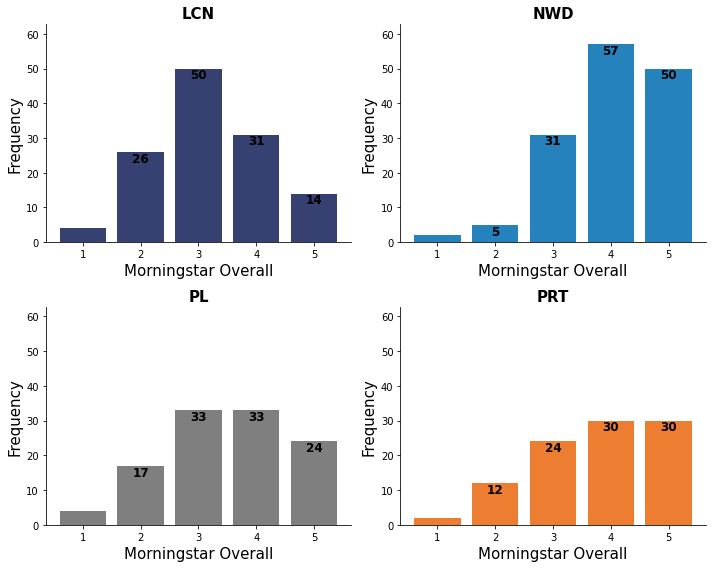

In [32]:
colors = {carriers_list[i]: colors_list[i] for i in range(len(carriers_list))}

fig = plt.figure(figsize=[10, 8])

def addlabels(x,y):
    for i in range(1, len(x)):
        i = i+1
        plt.text(i, y[i], y[i], ha='center', va='top', fontsize='large', fontweight='bold')

#Creating Hsitogram
ylim = max([carrier_dfs[carrier]['Morningstar Rating Overall'].value_counts().max() for carrier in carriers_list])*1.1
for carrier in enumerate(carrier_dfs.keys()):
  temp_df = ratings_df[ratings_df['Carrier']==carrier[1]]
  temp_df = temp_df[['Morningstar Rating Overall','Carrier']]
  ax = fig.add_subplot(2, 2, carrier[0]+1)
  title = temp_df.iloc[0,1]
  plt.ylim(0, ylim)
  plt.xlabel('Morningstar Overall',fontsize=15)
  plt.ylabel('Frequency',fontsize=15)
  plt.title(title, fontdict={'size':15, 'fontweight':'bold'})
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  x = temp_df['Morningstar Rating Overall'].value_counts().index
  y = temp_df['Morningstar Rating Overall'].value_counts()
  ax.bar(x, y, color=colors[carrier[1]])
  addlabels(x, np.round(y, 2))
  plt.tight_layout()

plt.savefig('Carrier Histograms.png')


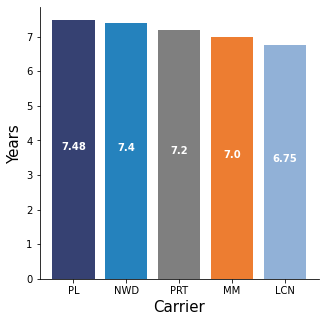

In [16]:

colors = {colors_list[i]: carriers_list[i] for i in range(len(carriers_list))}

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/2, y[i], ha = 'center', color='w', fontsize='medium', fontweight='bold')

#Seperating into tables for different sheets
man_tenure = pd.merge(agg_df_carrier['Manager Tenure (Average)'], agg_df_carrier['Manager Tenure (Average)'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
bar_colors = colors
data = man_tenure['Manager Tenure (Average)'].sort_values(ascending=False)
x = data.index
y = data.values
ax.bar(x, height=y, color=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Carrier',fontsize=15)
plt.ylabel('Years', fontsize=15)
addlabels(x, np.round(y, 2))
plt.savefig('Manager Tenure')

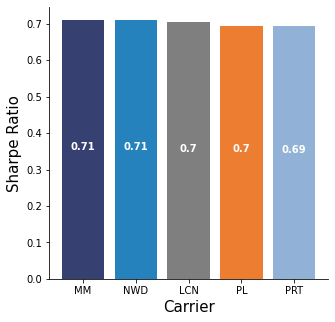

In [17]:
sharpe = pd.merge(agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'], agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
bar_colors = colors
data = sharpe['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'].sort_values(ascending=False)
x = data.index
y = data.values
ax.bar(x, height=y, color=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Carrier',fontsize=15)
plt.ylabel('Sharpe Ratio', fontsize=15)
addlabels(x, np.round(y, 2))
plt.savefig('Sharpe Ratio')

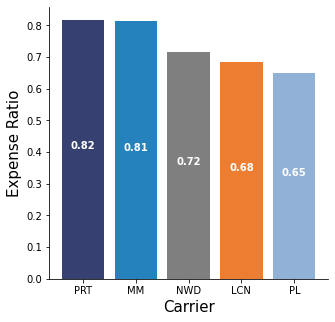

In [18]:
exp_ratio = pd.merge(agg_df_carrier['Prospectus Net Expense Ratio'], agg_df_carrier['Prospectus Net Expense Ratio'].rank(), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
data = exp_ratio['Prospectus Net Expense Ratio'].sort_values(ascending=False)
x = data.index
y = data.values
ax.bar(x, height=y, color=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Carrier',fontsize=15)
plt.ylabel('Expense Ratio', fontsize=15)
addlabels(x, np.round(y, 2))
plt.savefig('Expense Ratio')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


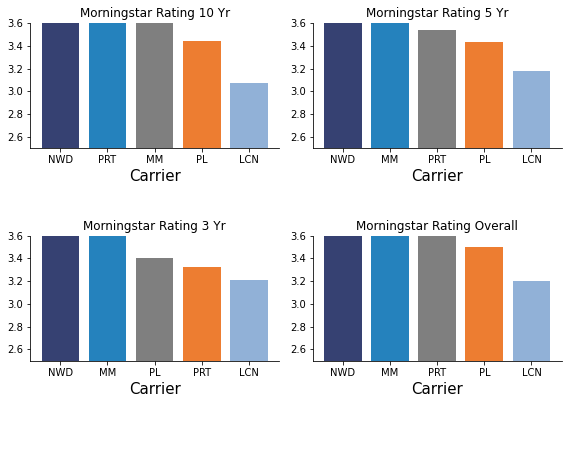

In [20]:
ms_ratings_cols = ['Morningstar Rating 10 Yr', 'Morningstar Rating 5 Yr', 'Morningstar Rating 3 Yr', 'Morningstar Rating Overall']
ms_ratings =  agg_df_carrier[ms_ratings_cols]

#--------------------------------------
for col in ms_ratings_cols:
  ms_ratings["{} Rank".format(col)] = ms_ratings[col].rank(ascending=False)
  
graph_cols = list(ms_ratings.columns[:4])

fig = plt.figure(figsize=(8, 6))

for i in enumerate(graph_cols):
  temp_df = ms_ratings[i[1]].sort_values(ascending=False)
  ax = fig.add_subplot(2, 2, i[0]+1)
  x = temp_df.index
  y = temp_df.values
  plt.xlabel('Carrier',fontsize=15)
  #plt.ylabel('',fontsize=15)
  plt.title(i[1])
  plt.ylim(2.5, 3.6)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.bar(x, y, color=colors)
  addlabels(x, np.round(y, 2))
  plt.tight_layout()

plt.savefig('ms_ratings.png')

In [ ]:
#--------------------------------------
rank_cat_cols = ['Total Ret % Rank Cat 1 Yr (Mo-End)', 'Total Ret % Rank Cat 3 Yr (Mo-End)', 'Total Ret % Rank Cat 5 Yr (Mo-End)', 'Total Ret % Rank Cat 10 Yr (Mo-End)']
rank_cat = agg_df_carrier[rank_cat_cols]

for col in rank_cat_cols:
  rank_cat["{} Rank".format(col)] = rank_cat[col].rank()

#--------------------------------------
total_ret_cols = ['Total Ret 1 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 3 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 5 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 10 Yr (Mo-End) Base Currency']
total_ret = agg_df_carrier.loc[:, total_ret_cols]

for col in total_ret_cols:
  total_ret["{} Rank".format(col)] = total_ret[col].rank(ascending=False)

#Best in class fund selection
asset_classes = ratings_df['Morningstar Category'].unique()

ratings_df['sum_ratings'] = ratings_df['Morningstar Rating 10 Yr'] + ratings_df['Morningstar Rating 5 Yr'] + ratings_df['Morningstar Rating 3 Yr'] + ratings_df['Morningstar Rating Overall']

ratings_df['avg_rankings'] = (ratings_df['Total Ret % Rank Cat 1 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 3 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 5 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 10 Yr (Mo-End)'])/4

ratings_df['total_score'] = ratings_df['sum_ratings'] + ratings_df['avg_rankings'].apply(lambda x: 1-(x/100))

bicf_list = []
for carrier in carriers_list:
  temp_df = ratings_df[ratings_df['Carrier']==carrier]
  for asset_class in asset_classes:
    class_df = temp_df[temp_df['Morningstar Category']==asset_class]
    class_df['BICF'] = ['yes' if i == class_df['total_score'].max() else 'no' for i in class_df['total_score']]
    bicf_list.append(class_df)
    
ratings_df = pd.concat(bicf_list)

tables_list = [ms_ratings, rank_cat, total_ret, man_tenure, exp_ratio, sharpe]

for table in tables_list:
  table = table.transpose()

In [ ]:
#writing to excel
xlwriter = pd.ExcelWriter('Subaccount Rankings Python Output.xlsx', engine='xlsxwriter')

man_tenure.to_excel(xlwriter, sheet_name='Manager Tenure')
xlwriter.sheets['Manager Tenure'].insert_image('D10', 'Manager Tenure.png')

ms_ratings.to_excel(xlwriter, sheet_name='Ratings')
xlwriter.sheets['Ratings'].insert_image('D10', 'ms_ratings.png')

sharpe.to_excel(xlwriter, sheet_name='Sharpe Ratio')
xlwriter.sheets['Sharpe Ratio'].insert_image('D10', 'Sharpe Ratio.png')

exp_ratio.to_excel(xlwriter, sheet_name='Expense Ratio')
xlwriter.sheets['Expense Ratio'].insert_image('D10', 'Expense Ratio.png')

rank_cat.to_excel(xlwriter, sheet_name='Return Rankings')
total_ret.to_excel(xlwriter, sheet_name='Total Return')

agg_df_class.to_excel(xlwriter, sheet_name='Asset Class Breakdown')

bicf_df = ratings_df[ratings_df['BICF']=='yes']
bicf_df.set_index(['Carrier','Morningstar Category'], inplace=True)
bicf_df.to_excel(xlwriter, sheet_name='BICFR')

ratings_df.set_index(['Carrier', 'Name'], inplace=True)
ratings_df.to_excel(xlwriter, sheet_name='All Data')

empty_sheet = pd.DataFrame()
empty_sheet.to_excel(xlwriter, sheet_name='Histogram')
worksheet=xlwriter.sheets['Histogram']
worksheet.insert_image('B2','Carrier Histograms.png')

counter = 0
for i in range(len(carriers_list)):
  list(carrier_dfs.values())[i].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[i]))

xlwriter.save()

xlwriter.close()